# **CODE-1: Pothole binary classification without keras hyperparameter tunning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Trial 2 Complete [00h 00m 23s]

Best val_accuracy So Far: None
Total elapsed time: 00h 01m 17s
Epoch 1/5
3/3 [==============================] - 7s 849ms/step - loss: 45.0397 - accuracy: 0.5208 - precision_1: 0.5000
Epoch 2/5
3/3 [==============================] - 2s 492ms/step - loss: 9.9417 - accuracy: 0.5616 - precision_1: 0.5179
Epoch 3/5
3/3 [==============================] - 2s 458ms/step - loss: 9.9492 - accuracy: 0.5208 - precision_1: 0.4167
Epoch 4/5
3/3 [==============================] - 2s 744ms/step - loss: 6.7264 - accuracy: 0.5342 - precision_1: 0.4667
Epoch 5/5
3/3 [==============================] - 2s 628ms/step - loss: 6.3324 - accuracy: 0.4795 - precision_1: 0.4444
Available keys:  dict_keys(['loss', 'accuracy', 'precision_1'])


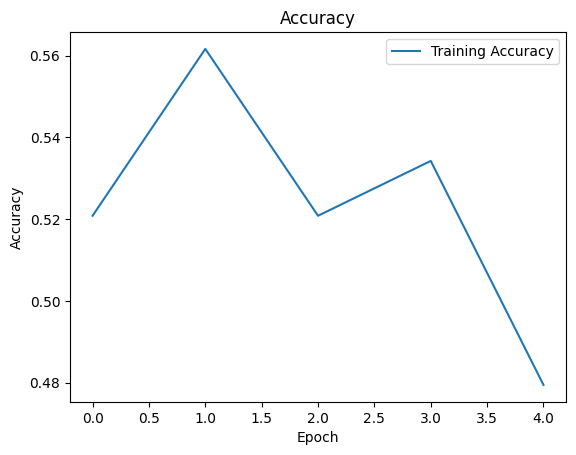

Found 40 images belonging to 2 classes.
1/1 [==============================] - 1s 867ms/step


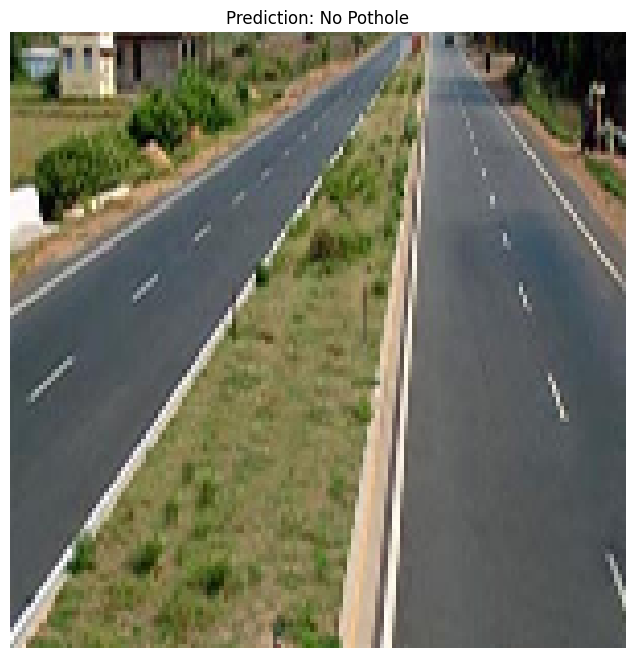

1/1 [==============================] - 0s 46ms/step


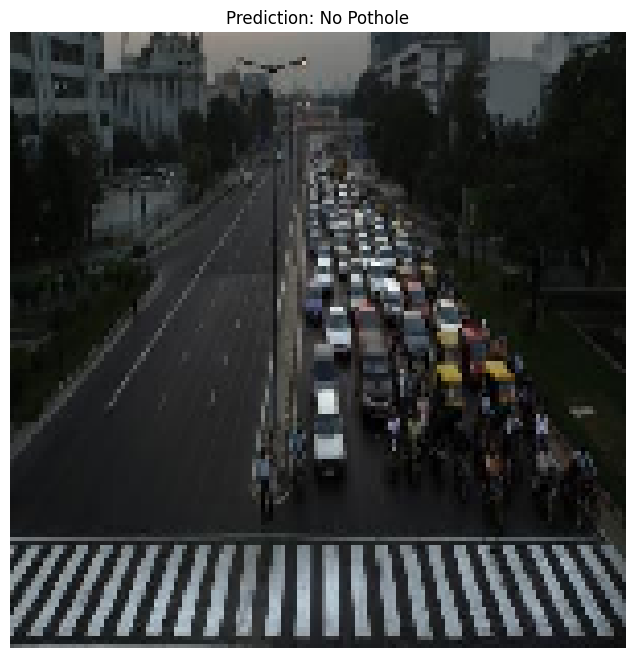

1/1 [==============================] - 0s 36ms/step


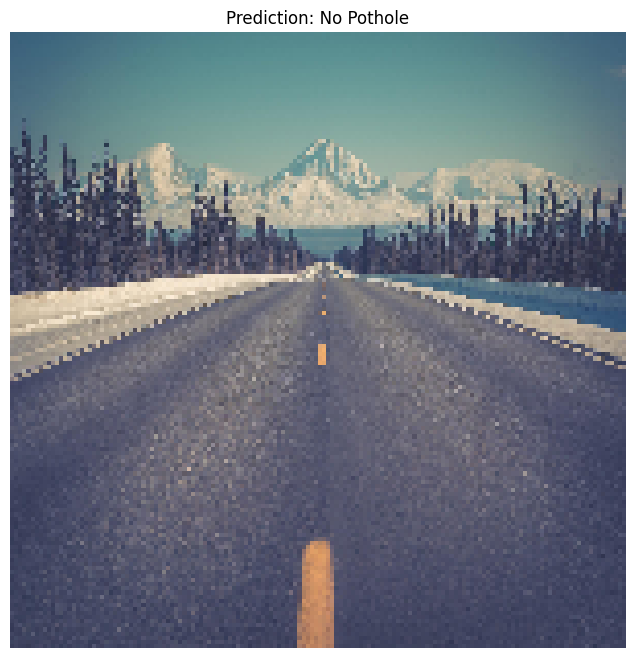

1/1 [==============================] - 0s 34ms/step


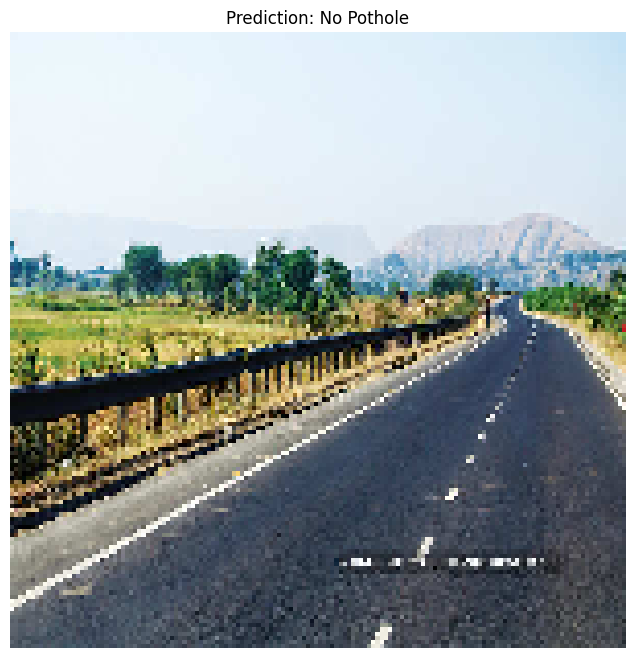

1/1 [==============================] - 0s 34ms/step


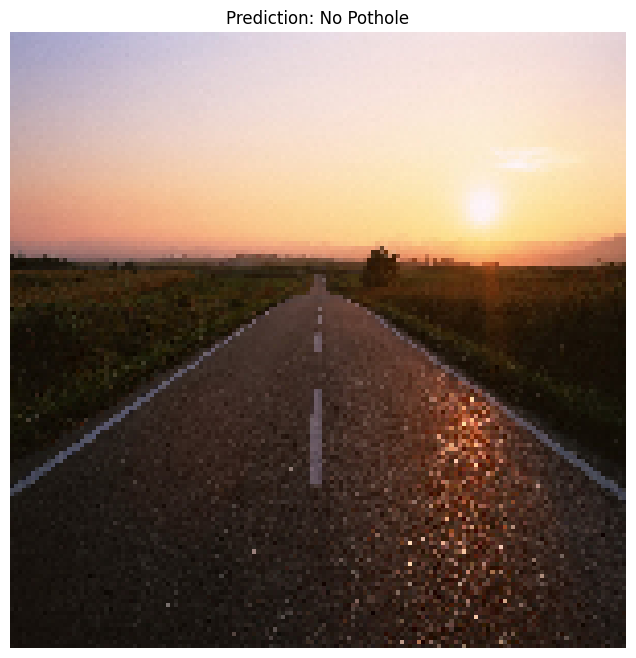

1/1 [==============================] - 0s 34ms/step


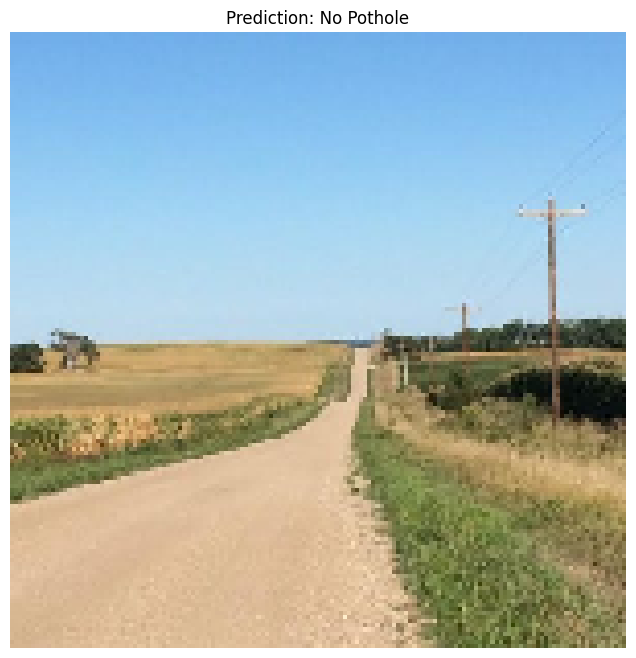

1/1 [==============================] - 0s 36ms/step


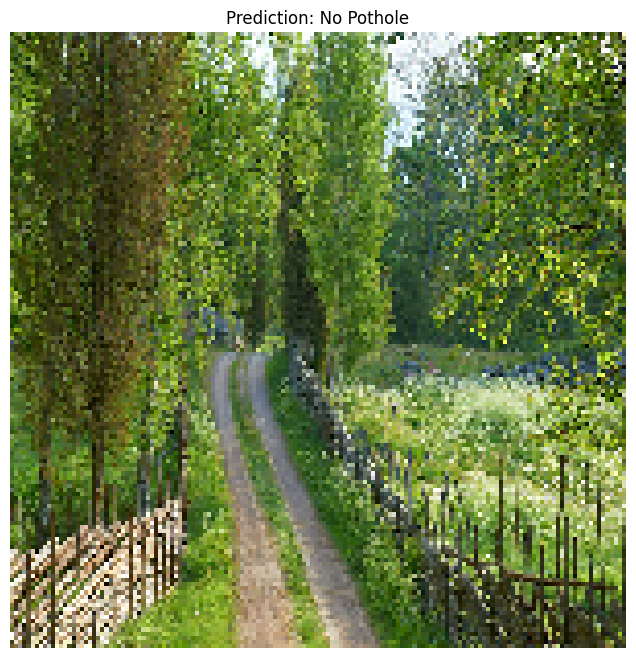

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow import keras
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Define and Compile the model
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision()])

    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir',
    project_name='pothole_detection_resnet'
)

# Train the model
tuner.search(train_generator,
             steps_per_epoch=train_generator.samples // train_generator.batch_size,
             epochs=5,
             validation_data=validation_generator,
             validation_steps=validation_generator.samples // validation_generator.batch_size)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
model = build_model(best_hyperparameters)

# Re-train the best model on the training set
# Re-train the best model on the training set
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Check what keys are available in history
print("Available keys: ", history.history.keys())

# Plotting the metrics
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Ensure 'val_accuracy' is in history before attempting to plot it
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
else:
    print("Warning: Validation accuracy not found in history.")

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prepare Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/test',
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Make Predictions and Visualize
predictions = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
rounded_predictions = np.round(predictions)

# Visualize the predictions
for i in range(len(rounded_predictions)):
    plt.figure(figsize=(8, 8))

    img, true_label = test_generator[i]

    prediction = best_model.predict(img)
    predicted_label = np.round(prediction[0])

    plt.imshow(img[0])

    if predicted_label == 1.0:
        plt.title('Prediction: Pothole')
    else:
        plt.title('Prediction: No Pothole')

    plt.axis('off')

    plt.show()

    if i > 5:  # Limit to 6 images for demonstration
        break


# **Code-2: Model interpretaion through LIME**

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1469cb35b6daa994ea1be38913cf604cf8b37f90377bca7d11b4f9c9f185c13d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
3/3 [==============================] - 34s 9s/step - loss: 2.5558 - accuracy: 0.5139 - precision: 0.4737
Epoch 2/5
3/3 [==============================] - 2s 324ms/step - loss: 2.8921 - accuracy: 0.4583 - precision: 0.4516
Epoch 3/5
3/3 [==============================] - 2s 942ms/step - loss: 3.6039 - accuracy: 0.4583 - precision: 0.4237
Epoch 4/5
3/3 [==============================] - 1s 381ms/step - loss: 2.1352 - accuracy: 0.5417 - precision: 0.5758
Epoch 5/5
3/3 [==============================] - 2s 318ms/step - loss: 1.9901 - accuracy: 0.5278 - precision: 0.5000
Found 40 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step


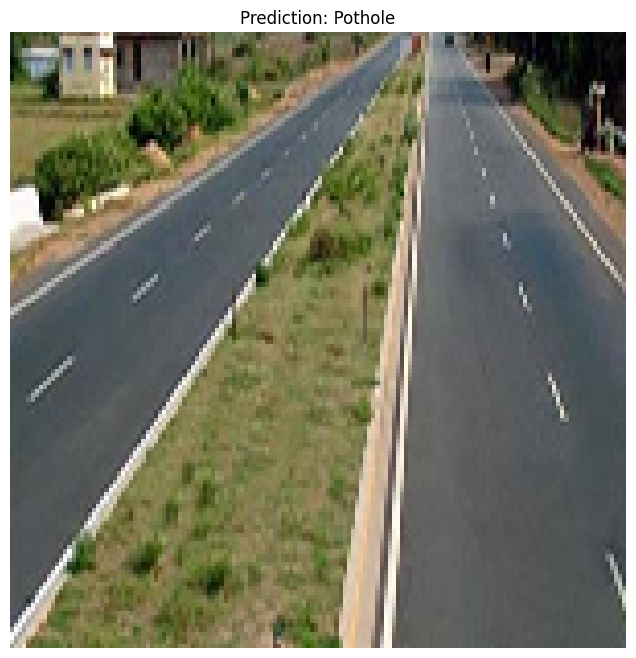

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


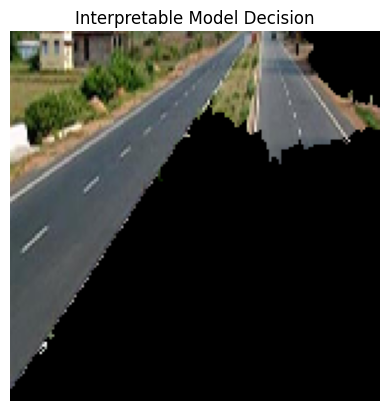

1/1 [==============================] - 0s 35ms/step


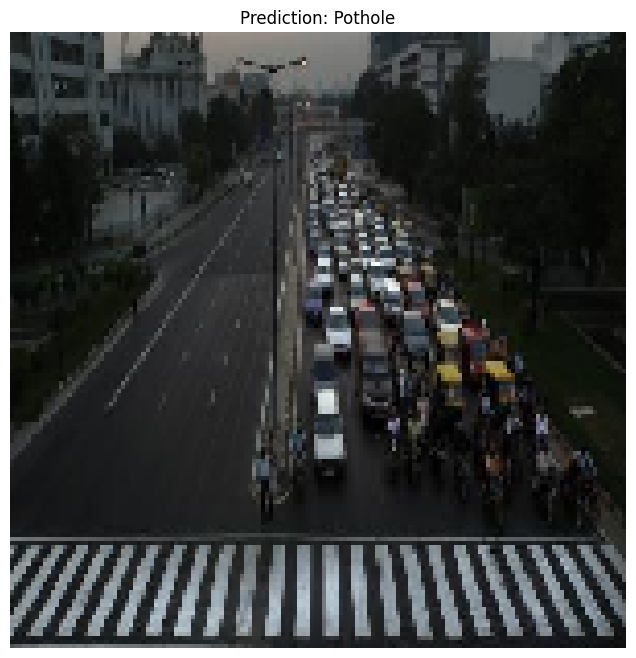

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


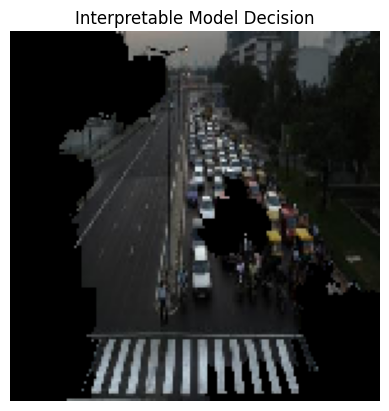

1/1 [==============================] - 0s 35ms/step


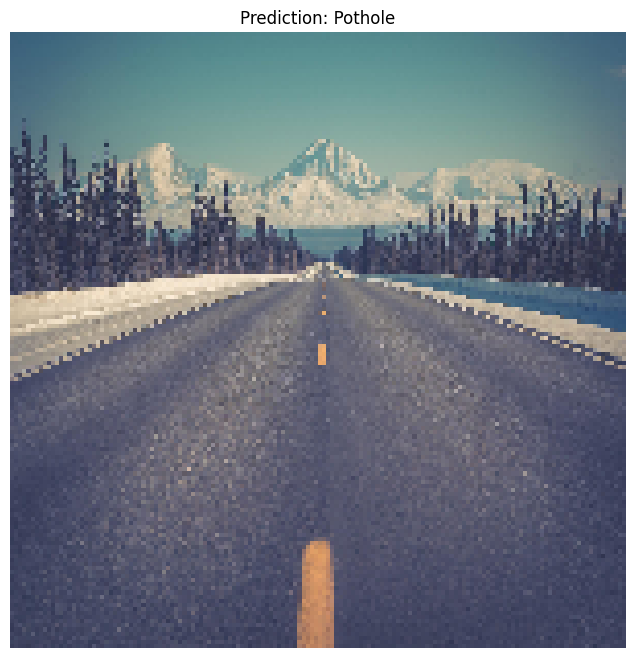

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


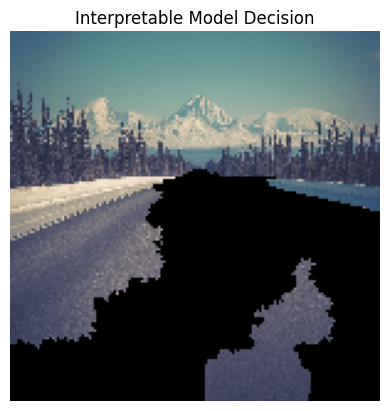

1/1 [==============================] - 0s 37ms/step


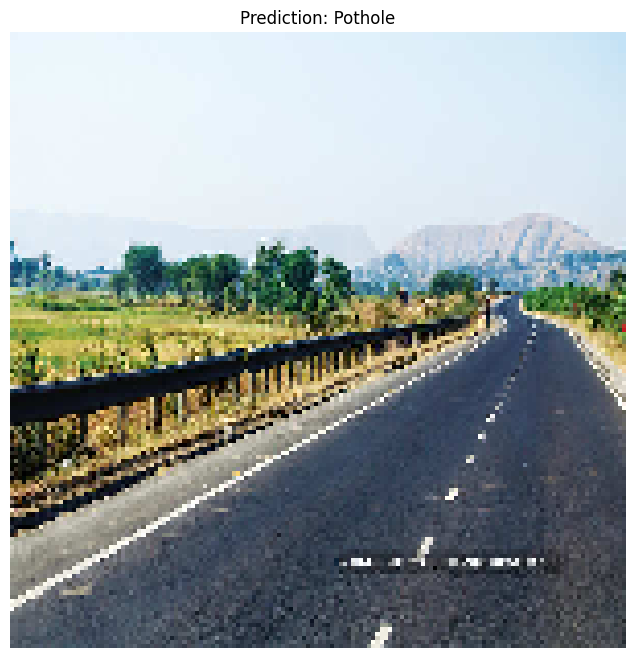

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


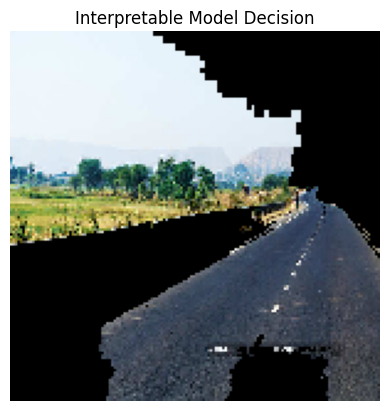

1/1 [==============================] - 0s 40ms/step


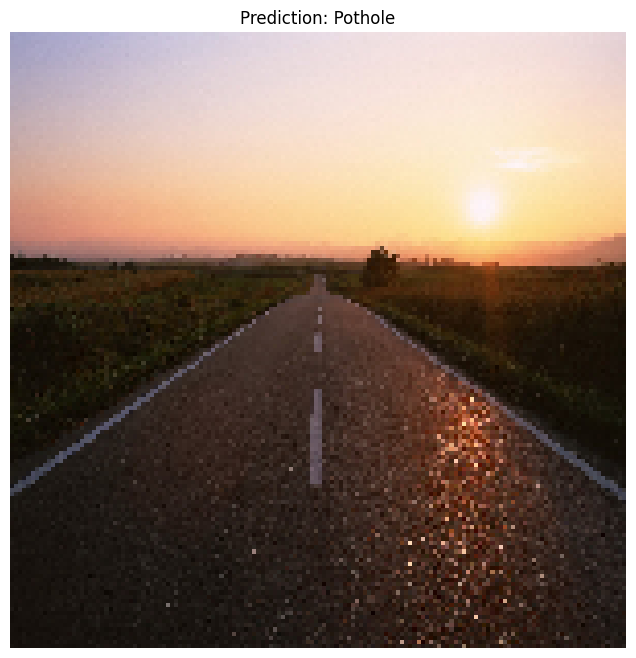

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


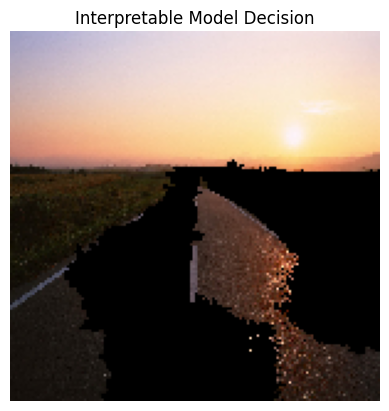

1/1 [==============================] - 0s 46ms/step


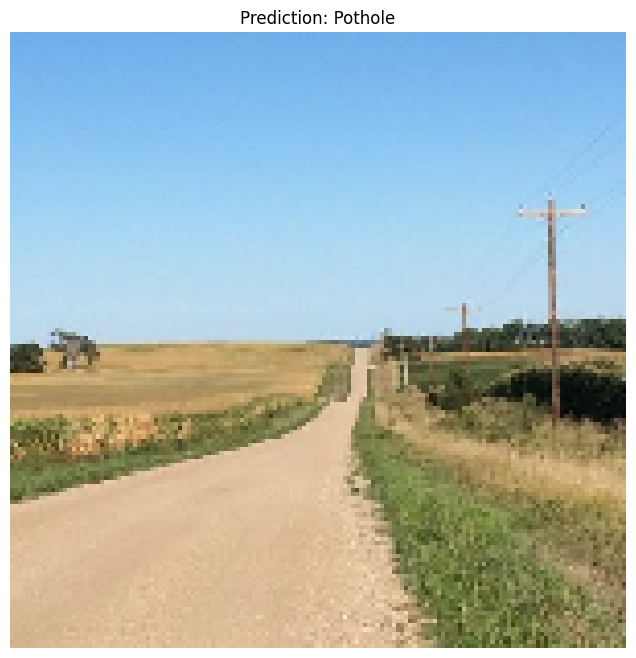

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


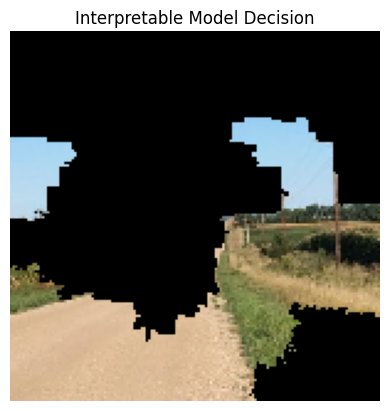

1/1 [==============================] - 0s 40ms/step


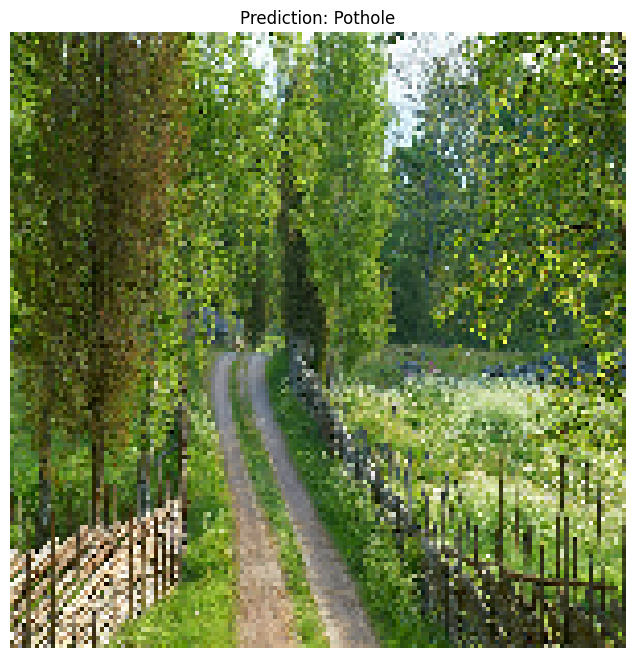

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


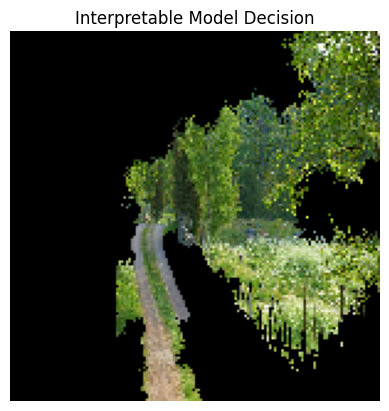

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Data Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Build and Compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Function to interpret the model's decision using LIME
def interpret_using_lime(model, image):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
    explanation = explainer.explain_instance(image,
                                             classifier_fn=lambda x: model.predict(x),  # Ensure this returns a 2D array
                                             top_labels=1,
                                             hide_color=0,
                                             num_samples=1000,
                                             segmentation_fn=segmenter)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(temp)
    plt.title('Interpretable Model Decision')
    plt.axis('off')
    plt.show()


# Prepare Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/test',
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Make Predictions and Visualize
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
rounded_predictions = np.round(predictions)

# Visualize the predictions
for i in range(len(rounded_predictions)):
    plt.figure(figsize=(8, 8))

    img, true_label = test_generator[i]
    img_display = img[0]

    prediction = model.predict(img)
    predicted_label = np.round(prediction[0])

    plt.imshow(img_display)

    if predicted_label == 1.0:
        plt.title('Prediction: Pothole')
    else:
        plt.title('Prediction: No Pothole')

    plt.axis('off')
    plt.show()

    # Use LIME to interpret the model's decision
    interpret_using_lime(model, img_display)

    if i > 5:  # Limit to 6 images for demonstration
        break


# **CODE-3:  Pothole binary classification with keras hyperparameter tunning (Optimization of Code-1 by random search method(in terms of accuracy and time)).**

In [ ]:
!pip install keras-tuner

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow import keras
from kerastuner.tuners import RandomSearch
import numpy as np

# Debugging with Callbacks
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"End epoch {epoch + 1} of training; got log keys: {logs.keys()}")

# Data Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Adjusted batch size for validation
validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=13,  # Reduced batch size
    class_mode='binary',
    subset='validation'
)

# Define and Compile the model
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=6,
    directory='my_dir',
    project_name='pothole_detection_resnet'
)

# Train the model
custom_callback = CustomCallback()
tuner.search(train_generator,
             steps_per_epoch=train_generator.samples // train_generator.batch_size,
             epochs=5,
             validation_data=validation_generator,
             validation_steps=validation_generator.samples // validation_generator.batch_size,
             callbacks=[custom_callback])

# Getting the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summarizing the best model
best_model.summary()


Trial 15 Complete [00h 02m 50s]
val_accuracy: 0.602564126253128

Best val_accuracy So Far: 0.6538461546103159
Total elapsed time: 00h 36m 02s
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                   

## **CODE-4: Pothole binary classification with some changes in code-1: cross-checking  data imbalance, unfreezing some layers of the model and incorporating early stopping to converge better. Anyway, Overfitting of the model still persists**

Found 105 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.2038 - accuracy: 0.5417 - precision_4: 0.4706 - recall_1: 0.3810

3/3 [==============================] - 41s 830ms/step - loss: 1.2038 - accuracy: 0.5417 - precision_4: 0.4706 - recall_1: 0.3810
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.6712 - precision_4: 0.6786 - recall_1: 0.5588

3/3 [==============================] - 1s 302ms/step - loss: 0.7035 - accuracy: 0.6712 - precision_4: 0.6786 - recall_1: 0.5588
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.6712 - precision_4: 0.6129 - recall_1: 0.6129

3/3 [==============================] - 2s 526ms/step - loss: 0.7495 - accuracy: 0.6712 - precision_4: 0.6129 - recall_1: 0.6129
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8021 - precision_4: 0.8000 - recall_1: 0.7442

3/3 [==============================] - 2s 987ms/step - loss: 0.4068 - accuracy: 0.8021 - precision_4: 0.8000 - recall_1: 0.7442
Epoch 5/50
3/3 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8219 - precision_4: 0.8065 - recall_1: 0.7812

3/3 [==============================] - 2s 779ms/step - loss: 0.3752 - accuracy: 0.8219 - precision_4: 0.8065 - recall_1: 0.7812
Epoch 6/50
3/3 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8767 - precision_4: 0.9655 - recall_1: 0.7778

3/3 [==============================] - 2s 483ms/step - loss: 0.3303 - accuracy: 0.8767 - precision_4: 0.9655 - recall_1: 0.7778
Epoch 7/50
3/3 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.8356 - precision_4: 0.8667 - recall_1: 0.7647

3/3 [==============================] - 1s 322ms/step - loss: 0.2833 - accuracy: 0.8356 - precision_4: 0.8667 - recall_1: 0.7647
Epoch 8/50
3/3 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9589 - precision_4: 0.9714 - recall_1: 0.9444

3/3 [==============================] - 2s 699ms/step - loss: 0.1464 - accuracy: 0.9589 - precision_4: 0.9714 - recall_1: 0.9444
Epoch 9/50
3/3 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9178 - precision_4: 0.9375 - recall_1: 0.8824

3/3 [==============================] - 1s 368ms/step - loss: 0.2272 - accuracy: 0.9178 - precision_4: 0.9375 - recall_1: 0.8824
Epoch 10/50
3/3 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9041 - precision_4: 0.8649 - recall_1: 0.9412

3/3 [==============================] - 2s 626ms/step - loss: 0.2194 - accuracy: 0.9041 - precision_4: 0.8649 - recall_1: 0.9412
Epoch 11/50
3/3 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9375 - precision_4: 0.9184 - recall_1: 0.9574

3/3 [==============================] - 3s 967ms/step - loss: 0.1535 - accuracy: 0.9375 - precision_4: 0.9184 - recall_1: 0.9574
Epoch 12/50
3/3 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9452 - precision_4: 0.9118 - recall_1: 0.9688

3/3 [==============================] - 2s 325ms/step - loss: 0.1272 - accuracy: 0.9452 - precision_4: 0.9118 - recall_1: 0.9688
Epoch 13/50
3/3 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9315 - precision_4: 0.9062 - recall_1: 0.9355

3/3 [==============================] - 2s 643ms/step - loss: 0.1566 - accuracy: 0.9315 - precision_4: 0.9062 - recall_1: 0.9355
Epoch 14/50
3/3 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9452 - precision_4: 0.9143 - recall_1: 0.9697

3/3 [==============================] - 2s 252ms/step - loss: 0.1009 - accuracy: 0.9452 - precision_4: 0.9143 - recall_1: 0.9697
Epoch 15/50
3/3 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9726 - precision_4: 0.9677 - recall_1: 0.9677

3/3 [==============================] - 1s 569ms/step - loss: 0.0732 - accuracy: 0.9726 - precision_4: 0.9677 - recall_1: 0.9677
Epoch 16/50
3/3 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9726 - precision_4: 0.9706 - recall_1: 0.9706

3/3 [==============================] - 2s 952ms/step - loss: 0.0544 - accuracy: 0.9726 - precision_4: 0.9706 - recall_1: 0.9706
Epoch 17/50
3/3 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9589 - precision_4: 0.9412 - recall_1: 0.9697

3/3 [==============================] - 2s 1s/step - loss: 0.1031 - accuracy: 0.9589 - precision_4: 0.9412 - recall_1: 0.9697
Epoch 18/50
3/3 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9688 - precision_4: 0.9778 - recall_1: 0.9565

3/3 [==============================] - 2s 727ms/step - loss: 0.0743 - accuracy: 0.9688 - precision_4: 0.9778 - recall_1: 0.9565
Epoch 19/50
3/3 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9896 - precision_4: 0.9756 - recall_1: 1.0000

3/3 [==============================] - 2s 423ms/step - loss: 0.0426 - accuracy: 0.9896 - precision_4: 0.9756 - recall_1: 1.0000
Epoch 20/50
3/3 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9479 - precision_4: 1.0000 - recall_1: 0.8889

3/3 [==============================] - 2s 619ms/step - loss: 0.1123 - accuracy: 0.9479 - precision_4: 1.0000 - recall_1: 0.8889
Epoch 21/50
3/3 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9589 - precision_4: 1.0000 - recall_1: 0.9189

3/3 [==============================] - 2s 725ms/step - loss: 0.1247 - accuracy: 0.9589 - precision_4: 1.0000 - recall_1: 0.9189
Epoch 22/50
3/3 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 415ms/step - loss: 0.0465 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 23/50
3/3 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9792 - precision_4: 1.0000 - recall_1: 0.9535

3/3 [==============================] - 3s 974ms/step - loss: 0.0437 - accuracy: 0.9792 - precision_4: 1.0000 - recall_1: 0.9535
Epoch 24/50
3/3 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 297ms/step - loss: 0.0259 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 25/50
3/3 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9726 - precision_4: 0.9744 - recall_1: 0.9744

3/3 [==============================] - 2s 464ms/step - loss: 0.0408 - accuracy: 0.9726 - precision_4: 0.9744 - recall_1: 0.9744
Epoch 26/50
3/3 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9896 - precision_4: 0.9762 - recall_1: 1.0000

3/3 [==============================] - 2s 473ms/step - loss: 0.0483 - accuracy: 0.9896 - precision_4: 0.9762 - recall_1: 1.0000
Epoch 27/50
3/3 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9863 - precision_4: 0.9697 - recall_1: 1.0000

3/3 [==============================] - 2s 308ms/step - loss: 0.0412 - accuracy: 0.9863 - precision_4: 0.9697 - recall_1: 1.0000
Epoch 28/50
3/3 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9677

3/3 [==============================] - 2s 437ms/step - loss: 0.0525 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9677
Epoch 29/50
3/3 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9863 - precision_4: 0.9677 - recall_1: 1.0000

3/3 [==============================] - 2s 713ms/step - loss: 0.0538 - accuracy: 0.9863 - precision_4: 0.9677 - recall_1: 1.0000
Epoch 30/50
3/3 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9863 - precision_4: 0.9655 - recall_1: 1.0000

3/3 [==============================] - 2s 482ms/step - loss: 0.0297 - accuracy: 0.9863 - precision_4: 0.9655 - recall_1: 1.0000
Epoch 31/50
3/3 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9667

3/3 [==============================] - 1s 315ms/step - loss: 0.0469 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9667
Epoch 32/50
3/3 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9767

3/3 [==============================] - 2s 475ms/step - loss: 0.0307 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9767
Epoch 33/50
3/3 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9863 - precision_4: 0.9706 - recall_1: 1.0000

3/3 [==============================] - 2s 381ms/step - loss: 0.0310 - accuracy: 0.9863 - precision_4: 0.9706 - recall_1: 1.0000
Epoch 34/50
3/3 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 3s 991ms/step - loss: 0.0179 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 35/50
3/3 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 1s 257ms/step - loss: 0.0212 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 36/50
3/3 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9773

3/3 [==============================] - 2s 519ms/step - loss: 0.0302 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9773
Epoch 37/50
3/3 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9778

3/3 [==============================] - 2s 489ms/step - loss: 0.0430 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9778
Epoch 38/50
3/3 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9863 - precision_4: 0.9714 - recall_1: 1.0000

3/3 [==============================] - 2s 824ms/step - loss: 0.0278 - accuracy: 0.9863 - precision_4: 0.9714 - recall_1: 1.0000
Epoch 39/50
3/3 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 457ms/step - loss: 0.0163 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 40/50
3/3 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 441ms/step - loss: 0.0126 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 41/50
3/3 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9767

3/3 [==============================] - 2s 637ms/step - loss: 0.0297 - accuracy: 0.9896 - precision_4: 1.0000 - recall_1: 0.9767
Epoch 42/50
3/3 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 752ms/step - loss: 0.0183 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 43/50
3/3 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9589 - precision_4: 0.9143 - recall_1: 1.0000

3/3 [==============================] - 1s 376ms/step - loss: 0.0683 - accuracy: 0.9589 - precision_4: 0.9143 - recall_1: 1.0000
Epoch 44/50
3/3 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9896 - precision_4: 0.9778 - recall_1: 1.0000

3/3 [==============================] - 2s 642ms/step - loss: 0.0269 - accuracy: 0.9896 - precision_4: 0.9778 - recall_1: 1.0000
Epoch 45/50
3/3 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9706

3/3 [==============================] - 2s 783ms/step - loss: 0.0237 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9706
Epoch 46/50
3/3 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 320ms/step - loss: 0.0079 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 47/50
3/3 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9792 - precision_4: 1.0000 - recall_1: 0.9535

3/3 [==============================] - 2s 525ms/step - loss: 0.0499 - accuracy: 0.9792 - precision_4: 1.0000 - recall_1: 0.9535
Epoch 48/50
3/3 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9697

3/3 [==============================] - 2s 468ms/step - loss: 0.0179 - accuracy: 0.9863 - precision_4: 1.0000 - recall_1: 0.9697
Epoch 49/50
3/3 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 361ms/step - loss: 0.0130 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Epoch 50/50
3/3 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000

3/3 [==============================] - 2s 487ms/step - loss: 0.0081 - accuracy: 1.0000 - precision_4: 1.0000 - recall_1: 1.0000
Available keys:  dict_keys(['loss', 'accuracy', 'precision_4', 'recall_1'])


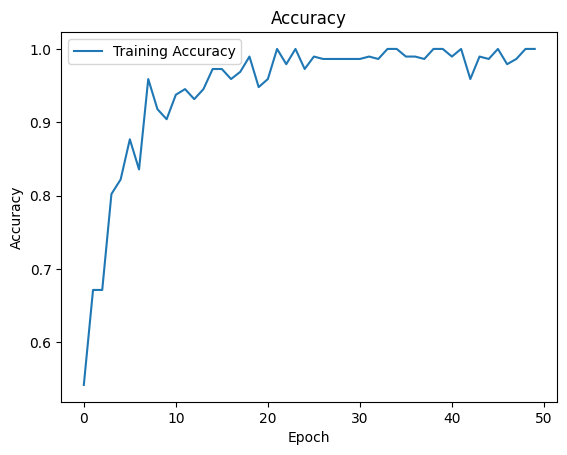

Found 40 images belonging to 2 classes.
1/1 [==============================] - 1s 874ms/step


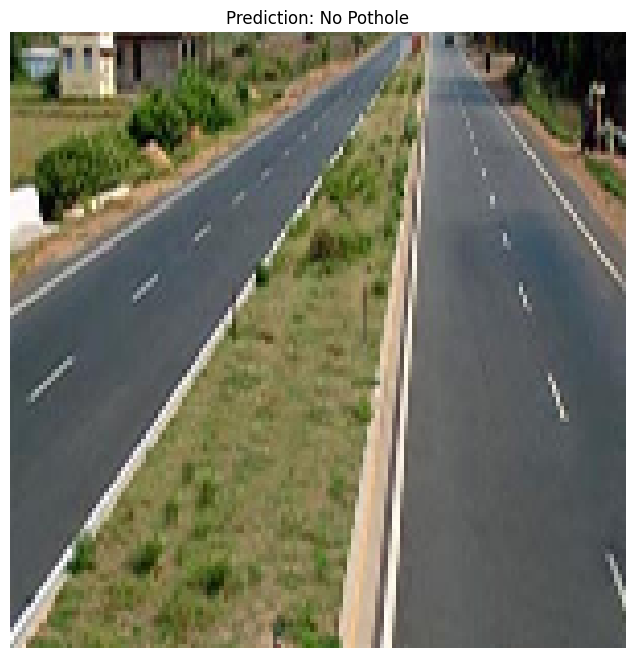

1/1 [==============================] - 0s 24ms/step


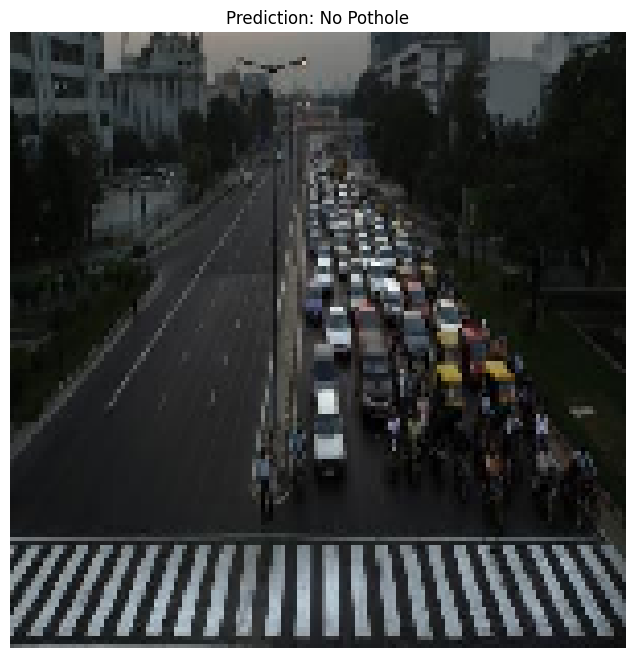

1/1 [==============================] - 0s 27ms/step


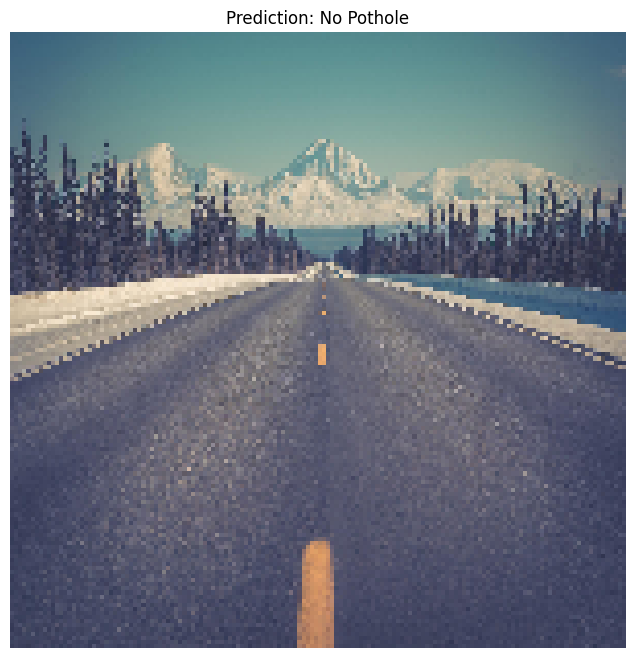

1/1 [==============================] - 0s 23ms/step


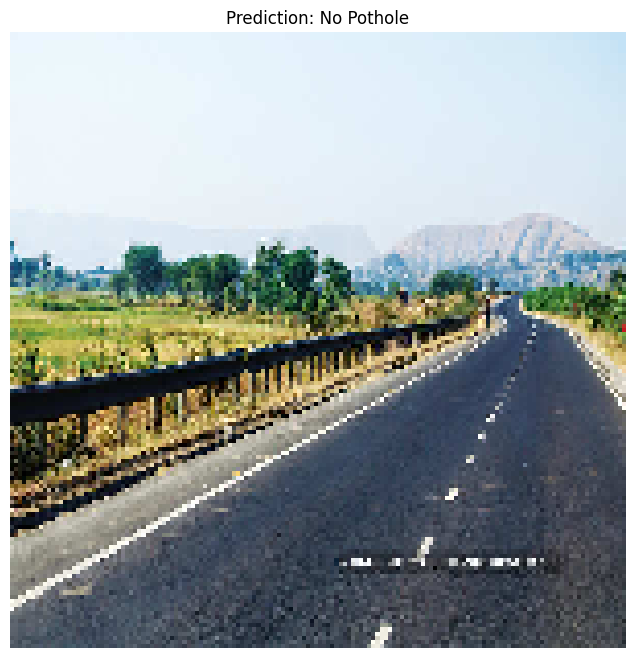

1/1 [==============================] - 0s 23ms/step


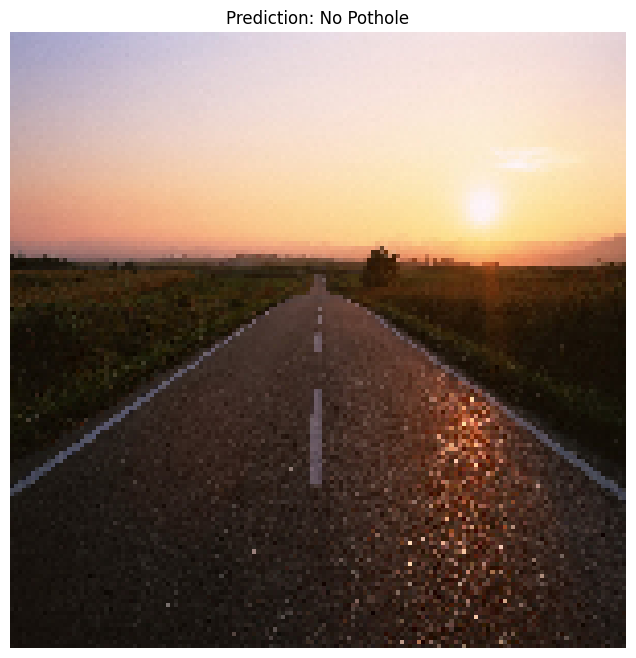

1/1 [==============================] - 0s 26ms/step


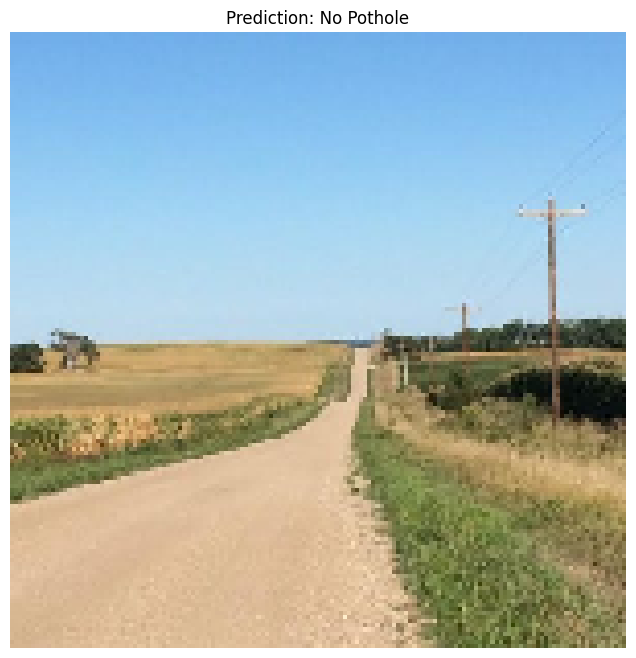

1/1 [==============================] - 0s 24ms/step


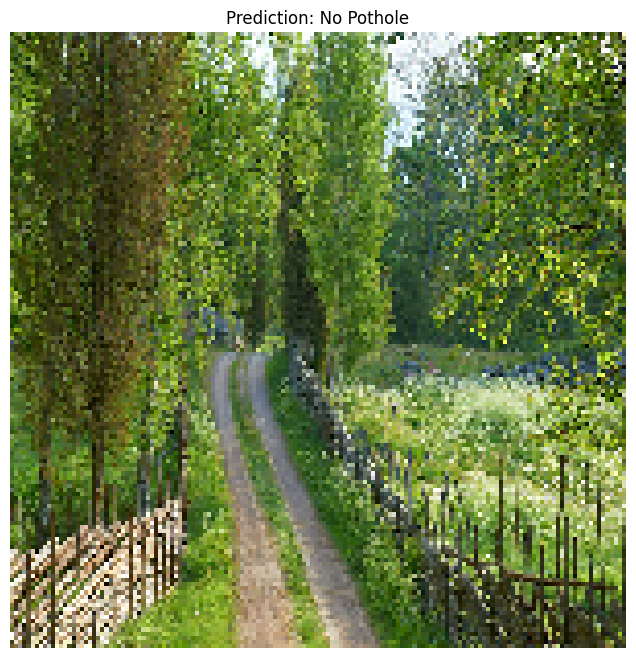

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Define and Compile the Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze some layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Increase epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# Check what keys are available in history
print("Available keys: ", history.history.keys())

# Plotting the metrics
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Check if 'val_accuracy' is in history before attempting to plot it
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
else:
    print("Warning: Validation accuracy not found in history.")

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prepare Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/test',
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Make Predictions and Visualize
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
rounded_predictions = np.round(predictions)

# Visualize the Predictions
for i in range(len(rounded_predictions)):
    plt.figure(figsize=(8, 8))
    img, true_label = test_generator[i]
    prediction = model.predict(img)
    predicted_label = np.round(prediction[0])

    plt.imshow(img[0])

    if predicted_label == 1.0:
        plt.title('Prediction: Pothole')
    else:
        plt.title('Prediction: No Pothole')

    plt.axis('off')
    plt.show()

    if i > 5:  # Limit to 6 images for demonstration
        break
